# Sea Ice Concentration

This a first pass of the information we might be interested in for the MIZ 2023 voyage and resulting research from a sea ice concentration dataset.

This example is using the NSIDC Sea Ice Concentration gridded data set

In [1]:
#useful py libraries
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


In [2]:
#some constants used here (maybe we should centralise?)
_defaultClimatDates=[1981,2010]
_eastAntarc=[71,160] #longitudes for east Antartica (E)
_concRange=[0.15,1]

A class to capture the data and processing functions

In [3]:
class seaIceConcMonthly:
    """This class does ...

        

        """
    
    def __climatology(self,da):
        """ For a provided da, calculate the mean and std dev, based on the default climatology dates defined at the start of the file.
        
        TO-DO: allow input of climatology dates?
        """
        
        
        climatDs=xr.Dataset()
        
        climatDs['ave']=da.where(
            (da.time.dt.year>=self.climatDates[0])
            *(da.time.dt.year<=self.climatDates[1]), 
            drop=True
        ).groupby('time.month').mean()

        climatDs['stDev']=da.where(
            (da.time.dt.year>=self.climatDates[0])
            *(da.time.dt.year<=self.climatDates[1]), 
            drop=True
        ).groupby('time.month').std()
        
        return climatDs
    
    def __init__(
        self, 
        concXr,
        gridAreas,
        climatDates=_defaultClimatDates
    ):
        """
        inputs:

        gridded concentration (range 0 to 1) as an xarray dataarray, 
        area of the grid cells (can be an xarray, or an nd array of the right dimensions),
        dates to use for determining climatology, (default 1981 to 2010) (any datetime format accepted by xr).
        
        This init function also calculates the sea ice area and extent for the provided dataarray
        
        """
        
        
        import xarray as xr
        import numpy as np

        self.da=concXr.where(
            (concXr<=_concRange[1]) #less than one to exclude flagged values 
            #TO-DO remove call to global var here??
        )
        self.gridAreas=gridAreas
        self.climatDates=climatDates

        #CALCULATE EXTENTS and AREA:
        # TO-DO change these to a property?
        #Every value between 0.15 and 1 is counted for extent
        hasSeaIceDa=(self.da>=_concRange[0])

        #for times where there is no data, store them for later
        allNans=(hasSeaIceDa.sum(['y','x'])==0)

        #calculate sea ice extent and area (so in theory, if there are lots of nans, this would give an erroneously low extent when we probably should discard that month rahter than keep it).
        self.extentDa=(
            hasSeaIceDa*self.gridAreas
        ).sum(['y','x'])
        
        self.areaDa=(
            self.da.where(hasSeaIceDa) #greater than 15%
            *self.gridAreas
        ).sum(['y','x'])

        #fill the times there is no data in with nans again (rather than 0s)
        self.extentDa[allNans]=np.nan
        self.areaDa[allNans]=np.nan
        
        self.extentClimatDs=self.__climatology(self.extentDa)
        self.areaClimatDs=self.__climatology(self.areaDa)
        
        
        #climatology for each grid cell
        self.concClimatDs=self.__climatology(self.da) #concXr.where(concXr<=_concRange[1]))

        #and gridded anoms
        self.anomsDa=self.da.groupby('time.month')-self.concClimatDs.ave
    


# Open the dataset

In this case, looking at the monthly averages of sea ice concentration

In [4]:
cdrXr = xr.open_dataset(
    '/g/data/jk72/MIZ/sidads.colorado.edu/DATASETS/NOAA/G02202_V4/south/aggregate/seaice_conc_monthly_sh_197811_202112_v04r00.nc',
)

cdrXr = cdrXr.swap_dims({'tdim':'time'})

In [5]:
cdrXr

<xarray.Dataset>
Dimensions:                           (time: 518, y: 332, x: 316)
Coordinates:
  * time                              (time) datetime64[ns] 1978-11-01 ... 20...
    xgrid                             (x) float32 ...
    ygrid                             (y) float32 ...
Dimensions without coordinates: y, x
Data variables:
    cdr_seaice_conc_monthly           (time, y, x) float32 ...
    nsidc_bt_seaice_conc_monthly      (time, y, x) float32 ...
    nsidc_nt_seaice_conc_monthly      (time, y, x) float32 ...
    projection                        |S1 ...
    qa_of_cdr_seaice_conc_monthly     (time, y, x) float32 ...
    stdev_of_cdr_seaice_conc_monthly  (time, y, x) float32 ...
    latitude                          (y, x) float32 ...
    longitude                         (y, x) float32 ...
Attributes: (12/40)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc_monthly
    metadata_link:             https://nsidc.org/data/g02202/versions/4/
    ...                        ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-22T15:54:57Z
    time_coverage_start:       1978-11-01T00:00:00Z
    time_coverage_end:         2021-12-31T23:59:59Z
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...

Annoyingly, the area of each grid cell is provided seperately

In [6]:
datFile=open('/g/data/jk72/MIZ/sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat', 'rb')
#pss25area_v3.dat: 316 columns x 332 rows
areasDmNd=np.fromfile(datFile, dtype=np.int32).reshape([332,316])

#Divide by 1000 to get km2
areasKmNd=areasDmNd/1000

# Climatologies for sea ice extent and area

Climatologies for extent and area of sea ice. There is no real time data shown, but this would be drawn in place of the 2017 year.

Extent is the total area of the ocean where the concetration of sea ice is estimated to be greater than 15%

Area is the area of the sea ice only (smaller than extent). Concentrations less than 15% were discarded prior to calculating this area? <b>(Confirm this?)</b>

In [7]:
antarcConc=seaIceConcMonthly(
    cdrXr.cdr_seaice_conc_monthly, 
    areasKmNd)

In [8]:
antarcConc.concClimatDs

<xarray.Dataset>
Dimensions:  (x: 316, y: 332, month: 12)
Coordinates:
    xgrid    (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
    ygrid    (y) float32 4.338e+06 4.312e+06 4.288e+06 ... -3.912e+06 -3.938e+06
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: x, y
Data variables:
    ave      (month, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    stDev    (month, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

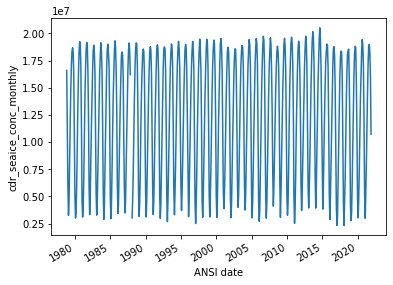

In [9]:
antarcConc.extentDa.plot()

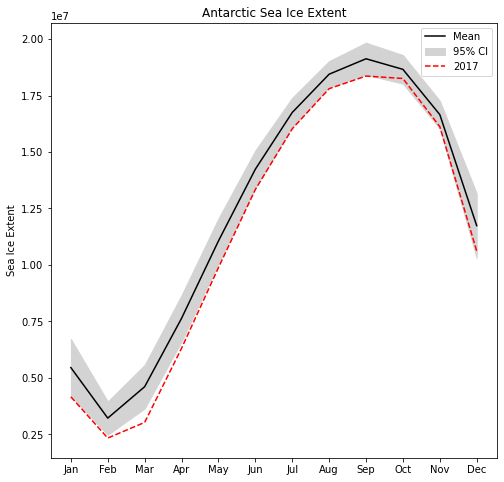

In [10]:
plt.figure(figsize=[8,8])

plt.subplot()

plt.plot(
    antarcConc.extentClimatDs.month,
    antarcConc.extentClimatDs.ave, 
    color='black'
)

plt.fill_between(
    antarcConc.extentClimatDs.month,
    antarcConc.extentClimatDs.ave-2*antarcConc.extentClimatDs.stDev, 
    antarcConc.extentClimatDs.ave+2*antarcConc.extentClimatDs.stDev,
    color='lightgrey'
)

plt.plot(
    [1,2,3,4,5,6,7,8,9,10,11,12],
    antarcConc.extentDa.where(antarcConc.extentDa.time.dt.year==2017, drop=True),
    color='red',
    linestyle='dashed'
)

drop=plt.xticks(
    ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
    labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)

plt.title('Antarctic Sea Ice Extent')
plt.ylabel('Sea Ice Extent')
plt.legend(['Mean','95% CI','2017'])

# 

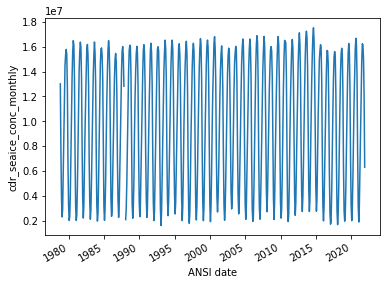

In [11]:
antarcConc.areaDa.plot()

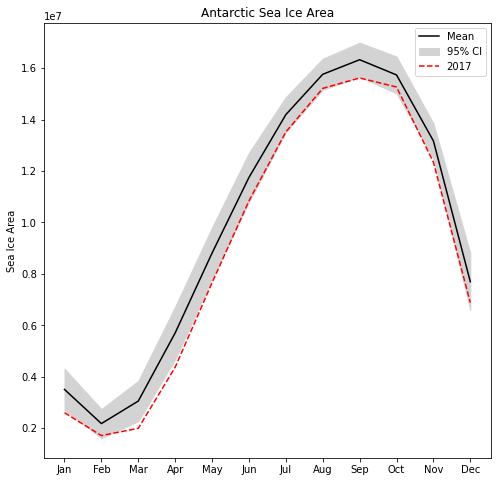

In [12]:
plt.figure(figsize=[8,8])

plt.subplot()

plt.plot(
    antarcConc.areaClimatDs.month,
    antarcConc.areaClimatDs.ave, 
    color='black'
)

plt.fill_between(
    antarcConc.areaClimatDs.month,
    antarcConc.areaClimatDs.ave-2*antarcConc.areaClimatDs.stDev, 
    antarcConc.areaClimatDs.ave+2*antarcConc.areaClimatDs.stDev,
    color='lightgrey'
)

plt.plot(
    [1,2,3,4,5,6,7,8,9,10,11,12],
    antarcConc.areaDa.where(antarcConc.areaDa.time.dt.year==2017, drop=True),
    color='red',
    linestyle='dashed'
)

drop=plt.xticks(
    ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
    labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)

plt.title('Antarctic Sea Ice Area')
plt.ylabel('Sea Ice Area')
plt.legend(['Mean','95% CI','2017'])

# distribution of sea ice

Monthly mean concentrations (1981-2010)

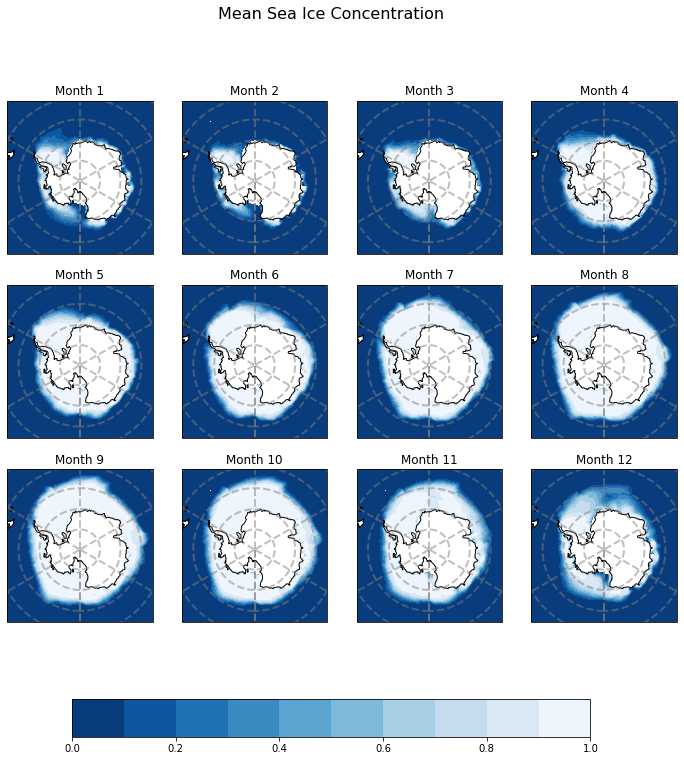

In [13]:
plt.figure(figsize=(12,13))
plt.suptitle('Mean Sea Ice Concentration', fontsize=16)

for iMonth in antarcConc.concClimatDs.month.values:
    
    ax = plt.subplot(4,4,iMonth,projection=ccrs.SouthPolarStereo())
    
    toPlot=antarcConc.concClimatDs.ave.sel(month=iMonth)
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        #levels=[0,.15,.80,1.00],
        levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

    gl = ax.gridlines(
        draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    )

    ax.coastlines()
    plt.title('Month ' + str(iMonth))
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.6,0.04]))
plt.show()

Alternative Hobbs et al used:
    
    climatological mean 15% SIC isoline
    
which seems easier, so ill go with that <b>(confirm?)</b>

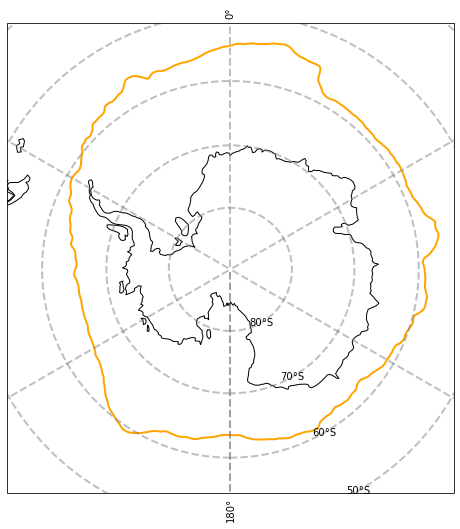

In [14]:
toPlot=antarcConc.concClimatDs.ave.sel(month=9)

plt.figure(figsize=(8,10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

plt.contour(
    toPlot.xgrid, 
    toPlot.ygrid, 
    toPlot,
    levels=[.15],
    transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
    colors='orange',
    linewidths=2
    )

gl = ax.gridlines(
    draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--'
)

ax.coastlines()


# anomalies in distribution of sea ice

In [15]:
year="2017"

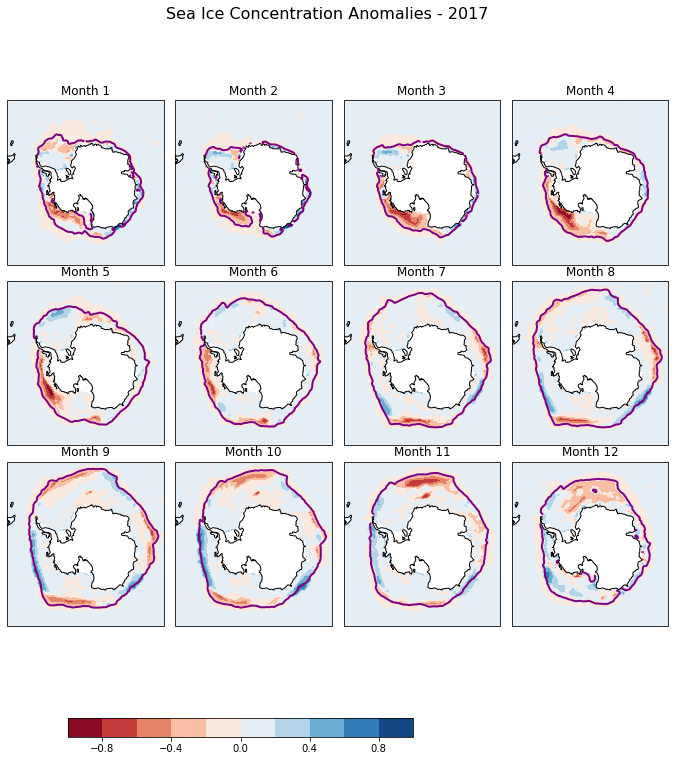

In [16]:
plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration Anomalies - 2017', fontsize=16)

for iMonth in antarcConc.concClimatDs.month.values:
    
    ax = plt.subplot(4,4,iMonth,projection=ccrs.SouthPolarStereo())
    
    toPlot=antarcConc.concClimatDs.ave.sel(month=iMonth)
    
    plt.contour(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=2
    )
    
    toPlot=antarcConc.anomsDa.sel(time=np.datetime64(year+"-"+"%02d" %iMonth))
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(-1,1.04,.2),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
        )
    
    #gl = ax.gridlines(
    #    draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    #)

    ax.coastlines()
    plt.title('Month ' + str(iMonth))

plt.subplots_adjust(hspace=0.1,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.4,0.02]))
plt.show()

# Repeat for east Antarctic only

In [17]:
_eastAntarc

[71, 160]

In [18]:
eAntarcConc=seaIceConcMonthly(cdrXr.where(
    (cdrXr.longitude>_eastAntarc[0])
    *(cdrXr.longitude<_eastAntarc[1])
).cdr_seaice_conc_monthly, areasKmNd)

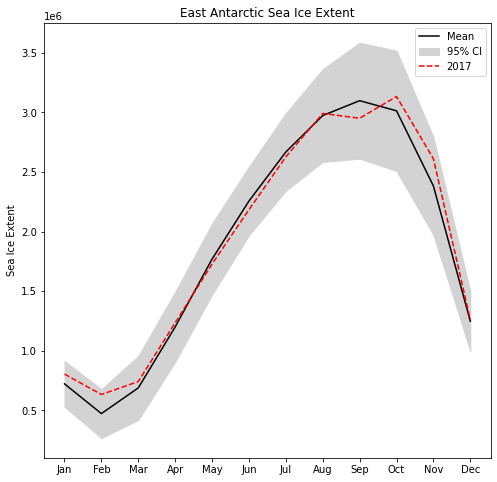

In [19]:
plt.figure(figsize=[8,8])

plt.subplot()

plt.plot(
    eAntarcConc.extentClimatDs.month,
    eAntarcConc.extentClimatDs.ave, 
    color='black'
)

plt.fill_between(
    eAntarcConc.extentClimatDs.month,
    eAntarcConc.extentClimatDs.ave-2*eAntarcConc.extentClimatDs.stDev, 
    eAntarcConc.extentClimatDs.ave+2*eAntarcConc.extentClimatDs.stDev,
    color='lightgrey'
)

plt.plot(
    [1,2,3,4,5,6,7,8,9,10,11,12],
    eAntarcConc.extentDa.where(eAntarcConc.extentDa.time.dt.year==2017, drop=True),
    color='red',
    linestyle='dashed'
)

drop=plt.xticks(
    ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
    labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)

plt.title('East Antarctic Sea Ice Extent')
plt.ylabel('Sea Ice Extent')
plt.legend(['Mean','95% CI','2017'])

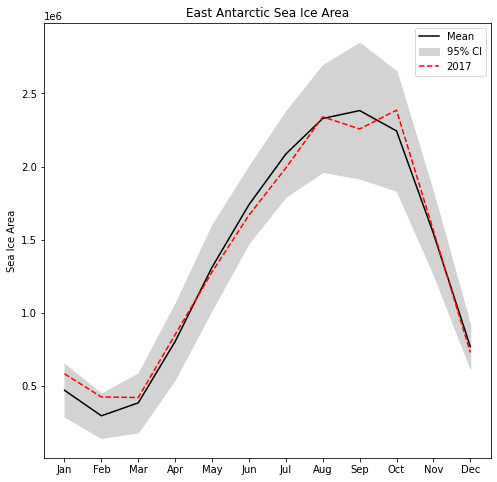

In [20]:
plt.figure(figsize=[8,8])

plt.subplot()

plt.plot(
    eAntarcConc.areaClimatDs.month,
    eAntarcConc.areaClimatDs.ave, 
    color='black'
)

plt.fill_between(
    eAntarcConc.areaClimatDs.month,
    eAntarcConc.areaClimatDs.ave-2*eAntarcConc.areaClimatDs.stDev, 
    eAntarcConc.areaClimatDs.ave+2*eAntarcConc.areaClimatDs.stDev,
    color='lightgrey'
)

plt.plot(
    [1,2,3,4,5,6,7,8,9,10,11,12],
    eAntarcConc.areaDa.where(eAntarcConc.areaDa.time.dt.year==2017, drop=True),
    color='red',
    linestyle='dashed'
)

drop=plt.xticks(
    ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
    labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)

plt.title('East Antarctic Sea Ice Area')
plt.ylabel('Sea Ice Area')
plt.legend(['Mean','95% CI','2017'])

In [21]:
# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
# (https://github.com/COSIMA/cosima-recipes/blob/master/Tutorials/Making_Maps_with_Cartopy.ipynb)

import matplotlib.path as mpath

def make_boundary_path(lons, lats):
    boundary_path = np.array([lons[-1, :], lats[-1, :]])
    boundary_path = np.append(boundary_path, np.array([lons[::-1, -1], lats[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[1, ::-1], lats[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[:, 1], lats[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

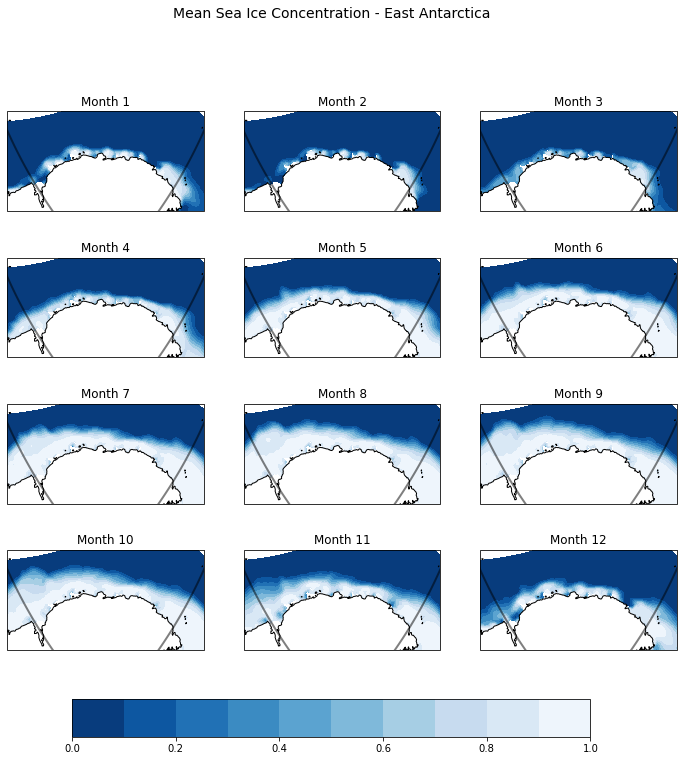

In [22]:
plt.figure(figsize=(12,13))
plt.suptitle('Mean Sea Ice Concentration - East Antarctica', fontsize=14)


for iMonth in antarcConc.concClimatDs.month.values:
    
    ax = plt.subplot(
        5,3,iMonth,
        projection=ccrs.Stereographic(central_longitude=(_eastAntarc[0]+_eastAntarc[1])/2)
        )
    
    ax.set_extent([_eastAntarc[0], _eastAntarc[1], -75, -55], crs=ccrs.PlateCarree())

    
    toPlot=antarcConc.concClimatDs.ave.sel(month=iMonth)
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[_eastAntarc[0], _eastAntarc[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title('Month ' + str(iMonth))
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.6,0.04]))
plt.show()

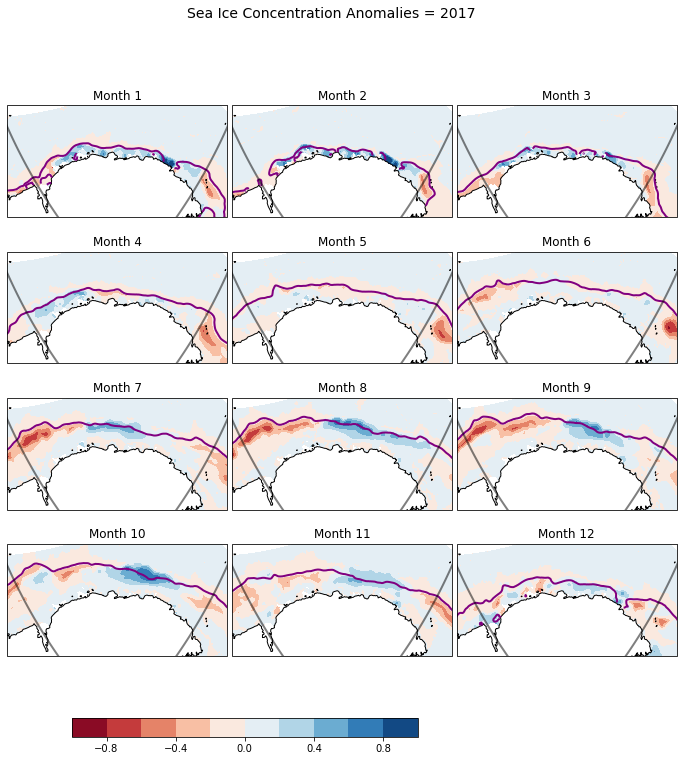

In [23]:
plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration Anomalies = 2017', fontsize = 14)

for iMonth in antarcConc.concClimatDs.month.values:
    
    ax = plt.subplot(5,3,iMonth,
        projection=ccrs.Stereographic(central_longitude=(_eastAntarc[0]+_eastAntarc[1])/2)
        )
    
    ax.set_extent([_eastAntarc[0], _eastAntarc[1], -75, -55], crs=ccrs.PlateCarree())

    
    toPlot=antarcConc.concClimatDs.ave.sel(month=iMonth)
    
    plt.contour(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=2
    )
    
    toPlot=antarcConc.anomsDa.sel(time=np.datetime64(year+"-"+"%02d" %iMonth))
    
    plt.contourf(
        toPlot.xgrid, 
        toPlot.ygrid, 
        toPlot,
        levels=np.arange(-1,1.04,.2),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
        )
    
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[_eastAntarc[0], _eastAntarc[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title('Month ' + str(iMonth))

plt.subplots_adjust(hspace=0.2,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.4,0.02]))
plt.show()

Whats missing:

- near-real time data

- validation

Some other plots could be:

- area anomalies over time (I dont think this is particularly useful because its still quite seasonal). 

- changes to max or min extent/area over time

- length of advance/retreat ( number of days, (could do gridded - would need to use the daily dataset for this, or just for whole area)